## Experiment 1

In [2]:
%reload_ext autoreload
%autoreload 3

from pathlib import Path
import torch.nn as nn
import pytorch_lightning as pl
from src.EEGNet.dataloader.dataloader import EEGNetDataModule
from src.EEGNet.dataloader.waveletsloader import Wavelets
from src.EEGNet import AutoEncoder
from src.EEGNet.models.wrapper import Wrapper, SeperateClassifier
from src.EEGNet.models.vae import ConvVAE
from src.EEGNet.models.autoencoders import RNNAutoencoder

In [3]:
# Parameters
segment_size = 128
n_fft = None
batch_size = 512
n_channels = 61
max_epochs = 500
depth = 3
n_subs = 2 # TODO: increase the number of subjects
data_dir = Path('data/LEMON_data/xarray/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp_with_pos.nc5')
read_from_checkpoints = False
checkpoints_dir = Path('lightning_logs/Model 1/checkpoints/epoch=59-step=540.ckpt')

In [11]:
# model params
datamodule = EEGNetDataModule(data_dir=data_dir, batch_size=batch_size, segment_size=segment_size, n_subjects=n_subs,
                              split_type='subject', shuffling='split_shuffle', stratified=True)
model = Wrapper(n_subjects=n_subs,
                n_channels=n_channels,
                n_timepoints=segment_size,
                out_channel=256,
                use_classifier=True,
                use_decoder=True,
                use_1x1_conv=False,
                use_subject_layers=False,
                use_channel_merger=False,
                dropout=0,
                depth=4,
                kernel_size=3,
                stride=1,
                n_fft=None,
                hidden=256,
                joint_embedding=False,
                encoderArc='MLP',
                )
if read_from_checkpoints:
    model = Wrapper.load_from_checkpoint(checkpoints_dir)
model
# trainer = pl.Trainer(accelerator='cpu', log_every_n_steps=1, deterministic='warn')
# trainer.fit(model, datamodule=datamodule)

Wrapper(
  (encoder): MLPAutoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=7808, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=64, bias=True)
      (5): ReLU()
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=32, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=128, bias=True)
      (3): ReLU()
      (4): Linear(in_features=128, out_features=256, bias=True)
      (5): ReLU()
      (6): Linear(in_features=256, out_features=7808, bias=True)
      (7): ReLU()
    )
  )
  (classifier): Classifier(
    (model): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU()
      (2): Linear(in_features=16, out_features=2, bias=True)
      (3): Sigmoid()
    )
  )
)

### Training

In [4]:
# model params
datamodule = EEGNetDataModule(data_dir=data_dir, batch_size=batch_size, segment_size=segment_size, n_subjects=n_subs,
                              split_type='subject', shuffling='split_shuffle', stratified=True)
model = Wrapper(n_subjects=n_subs,
                embedded_time_dim=62,  # 14 when using wavelets, this is a temporary fix
                use_classifier=True,
                use_decoder=False,
                use_1x1_conv=False,
                use_subject_layers=False,
                use_channel_merger=False,
                dropout=0.4,
                n_fft=None,
                joint_embedding=True
                )

if read_from_checkpoints:
    model = Wrapper.load_from_checkpoint(checkpoints_dir)

# trainer = pl.Trainer(accelerator='cpu', log_every_n_steps=1, deterministic='warn')
# trainer.fit(model, datamodule=datamodule)

## Fine-tune classifier

In [ ]:
# Data
datamodule = EEGNetDataModule(data_dir=data_dir, batch_size=batch_size, segment_size=segment_size, n_subjects=n_subs,
                              split_type='subject', shuffling='split_shuffle', stratified=True)
# Fine-tune classifier
pretrained_encoder_checkpoint_path = 'models/b2bnet_segment-360_epochs-778.ckpt'

cls_model = SeperateClassifier(pretrained_encoder_checkpoint_path, n_labels=2)
finetune_trainer = pl.Trainer(accelerator='cpu',
                              log_every_n_steps=1, deterministic='warn')

finetune_trainer.fit(cls_model, datamodule=datamodule)

### Experimenting

#### wavelets

In [ ]:
data_dir = Path('data/wavelets/wavelets.nc5')
datamodule = Wavelets(data_dir=data_dir, batch_size=batch_size)
datamodule.prepare_data()
x = datamodule.train_dataset[:][0].squeeze(1)

In [ ]:
n_embeddings = 32
batch_size, n_channels, n_features = x.shape

encode = nn.Sequential(
    nn.Conv1d(n_channels, n_channels * 2, kernel_size=4, stride=1),
    nn.ReLU(),
    nn.Conv1d(n_channels * 2, n_channels * 4, kernel_size=4, stride=1),
    nn.ReLU(),
    nn.Conv1d(n_channels * 4, n_channels * 8, kernel_size=4, stride=1),
    nn.ReLU(),
    nn.Conv1d(n_channels * 8, n_channels * 16, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(n_channels * 16, n_embeddings)
)

decode = nn.Sequential(
    nn.Linear(n_embeddings, n_channels * 16),
    nn.Unflatten(dim=1, unflattened_size=(n_channels * 16, 1)),
    nn.ConvTranspose1d(n_channels * 16, n_channels * 8, kernel_size=3, stride=1),
    nn.ReLU(),
    nn.ConvTranspose1d(n_channels * 8, n_channels * 4, kernel_size=4, stride=1),
    nn.ReLU(),
    nn.ConvTranspose1d(n_channels * 4, n_channels * 2, kernel_size=4, stride=1),
    nn.ReLU(),
    nn.ConvTranspose1d(n_channels * 2, n_channels, kernel_size=4, stride=1),
    nn.Sigmoid()
)

h = encode(x)
x_hat = decode(h)


#### Timeseries

In [ ]:
data_dir = Path('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp.nc5')
datamodule = TimeDimSplit(data_dir=data_dir, batch_size=batch_size, segment_size=128 * 4)
datamodule.prepare_data()
x = datamodule.train_dataset[:][0]
x = x[:2, :, :]
x = x.permute(0, 2, 1)
x.shape

torch.Size([2, 61, 512])

In [ ]:
n_embeddings = 32
batch_size, n_channels, n_features = x.shape

encoder = nn.Sequential(
nn.Conv1d(n_channels, n_channels, kernel_size=4, stride=1),
nn.ReLU(),
nn.Conv1d(n_channels, n_channels * 2, kernel_size=4, stride=1),
nn.ReLU(),
nn.Conv1d(n_channels * 2, n_channels * 4, kernel_size=4, stride=1),
nn.ReLU(),
nn.Conv1d(n_channels * 4, n_channels * 8, kernel_size=4, stride=1),
nn.ReLU(),
nn.Conv1d(n_channels * 8, n_channels * 16, kernel_size=4, stride=1),
nn.ReLU(),
nn.Flatten(),
nn.Linear(n_channels * 16, n_embeddings)
)

decoder = nn.Sequential(
nn.Linear(n_embeddings, n_channels * 16),
nn.Unflatten(dim=1, unflattened_size=(n_channels * 16, 1)),
nn.ConvTranspose1d(n_channels * 16, n_channels * 8, kernel_size=4, stride=1),
nn.ReLU(),
nn.ConvTranspose1d(n_channels * 8, n_channels * 4, kernel_size=4, stride=1),
nn.ReLU(),
nn.ConvTranspose1d(n_channels * 4, n_channels * 2, kernel_size=4, stride=1),
nn.ReLU(),
nn.ConvTranspose1d(n_channels * 2, n_channels, kernel_size=4, stride=1),
nn.ReLU(),
nn.ConvTranspose1d(n_channels, n_channels, kernel_size=4, stride=1),
nn.ReLU(),
nn.Sigmoid()
)

h = encoder(x)
x_hat = decoder(h)

In [ ]:
n_embeddings = 64
batch_size, n_channels, n_features = x.shape

e1 = nn.Conv1d(n_channels, n_channels*2, kernel_size=4, stride=2)
e2 = nn.Conv1d(n_channels*2, n_channels*4, kernel_size=4, stride=2)
e3 = nn.Conv1d(n_channels*4, n_channels*8, kernel_size=4, stride=2)
e4 = nn.Flatten()
e5 = nn.Linear(n_channels*8*62, n_embeddings)

d1 = nn.Linear(n_embeddings, n_channels*8*62)
d2 = nn.Unflatten(dim=1, unflattened_size=(n_channels*8, 62))
d3 = nn.ConvTranspose1d(n_channels*8, n_channels*4, kernel_size=4, stride=2)
d4 = nn.ConvTranspose1d(n_channels*4, n_channels*2, kernel_size=4, stride=2, output_padding=1)
d5 = nn.ConvTranspose1d(n_channels*2, n_channels, kernel_size=4, stride=2)

h =  e5(e4(e3(e2(e1(x)))))
e1(x).shape, e2(e1(x)).shape, e3(e2(e1(x))).shape, e4(e3(e2(e1(x)))).shape, e5(e4(e3(e2(e1(x))))).shape, d1(h).shape, d2(d1(h)).shape, d3(d2(d1(h))).shape, d4(d3(d2(d1(h)))).shape, d5(d4(d3(d2(d1(h))))).shape

(torch.Size([2, 122, 255]),
 torch.Size([2, 244, 126]),
 torch.Size([2, 488, 62]),
 torch.Size([2, 30256]),
 torch.Size([2, 64]),
 torch.Size([2, 30256]),
 torch.Size([2, 488, 62]),
 torch.Size([2, 244, 126]),
 torch.Size([2, 122, 255]),
 torch.Size([2, 61, 512]))

Text(0.5, 1.0, 'Output')

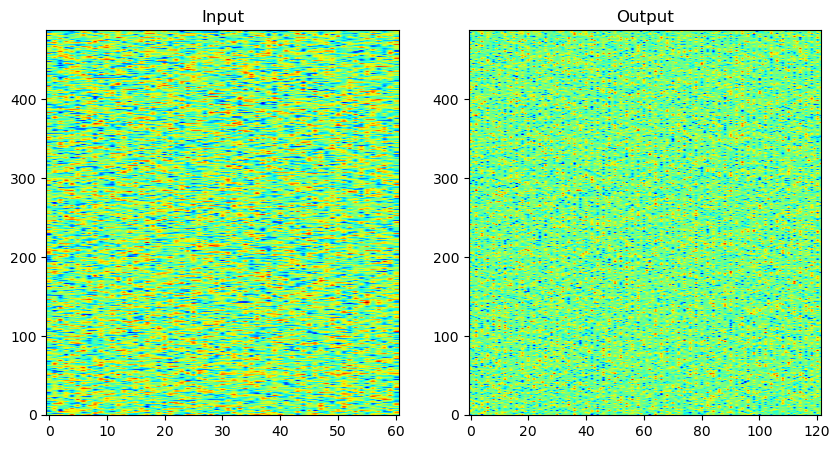

In [ ]:
# plot the output
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(out1.detach().numpy()[0, :, :], aspect='auto', origin='lower', cmap='jet')
axs[0].set_title('Input')
axs[1].imshow(out2.detach().numpy()[0, :, :], aspect='auto', origin='lower', cmap='jet')
axs[1].set_title('Output')

##### VAE

In [ ]:
# data
data_dir = Path('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp.nc5')
datamodule = TimeDimSplit(data_dir=data_dir, batch_size=batch_size, segment_size=128 * 4)
datamodule.prepare_data()
x = datamodule.train_dataset[:][0]
x = x[:3, :, :]
x = x.permute(0, 2, 1)
x.shape

torch.Size([3, 61, 512])

In [ ]:
import torch
n_embeddings = 32
# Encoder
encoder_conv = nn.Sequential(
    nn.Conv1d(n_channels, n_channels * 2, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv1d(n_channels * 2, n_channels * 4, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Conv1d(n_channels * 4, n_channels * 8, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.Flatten(),
)
encoder_fc_mu = nn.Linear(n_channels * 8 * 62, n_embeddings)
encoder_fc_log_var = nn.Linear(n_channels * 8 * 62, n_embeddings)

# Decoder
decoder = nn.Sequential(
    nn.Linear(n_embeddings, n_channels * 8 * 62),
    nn.Unflatten(dim=1, unflattened_size=(n_channels * 8, 62)),
    nn.ReLU(),
    nn.ConvTranspose1d(n_channels * 8, n_channels * 4, kernel_size=4, stride=2),
    nn.ReLU(),
    nn.ConvTranspose1d(n_channels * 4, n_channels * 2, kernel_size=4, stride=2, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose1d(n_channels * 2, n_channels, kernel_size=4, stride=2),
    nn.ReLU()
)


In [ ]:
x_ = encoder_conv(x)
mu = encoder_fc_mu(x_)
log_var = encoder_fc_log_var(x_)
std = torch.exp(0.5 * log_var)
eps = torch.randn_like(std)
z = mu + eps * std
x_hat = decoder(z)

##### Visualization
This section visualize the heatmap and latend representations before and after tranings.

In [ ]:
import torch
import matplotlib.pyplot as plt

In [ ]:
# upload data and model
# data
data_dir = Path('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp.nc5')
datamodule = TimeDimSplit(data_dir=data_dir, batch_size=batch_size, segment_size=128 * 4)
datamodule.prepare_data()
x = datamodule.train_dataset[:][0]
x = x[:50, :, :]
x = x.permute(0, 2, 1)
num = range(1, 5)
epochs = [17, 55, 98, 125, 129]
steps = [162, 504, 891, 1134, 1170]
models = []

# model
for num, epo, stp in zip(num, epochs, steps):
    checkpoints_dir = Path(f'notebooks/lightning_logs/version_52_{num}/checkpoints/epoch={epo}-step={stp}.ckpt')
    models.append(ConvVAE.load_from_checkpoint(checkpoints_dir))

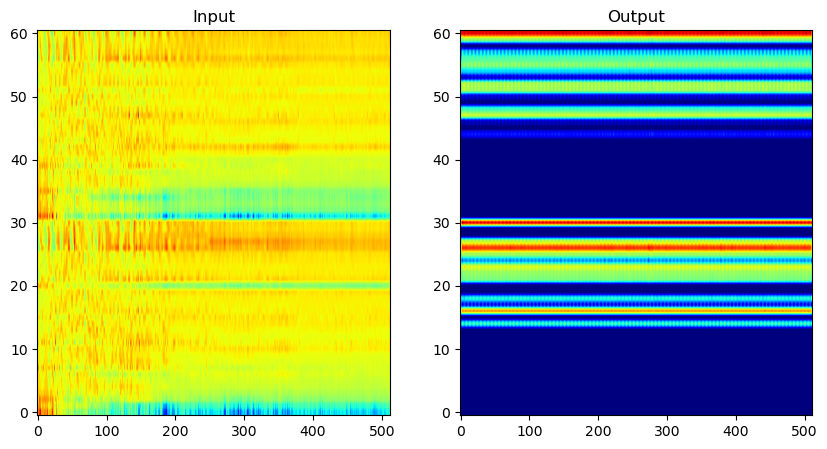

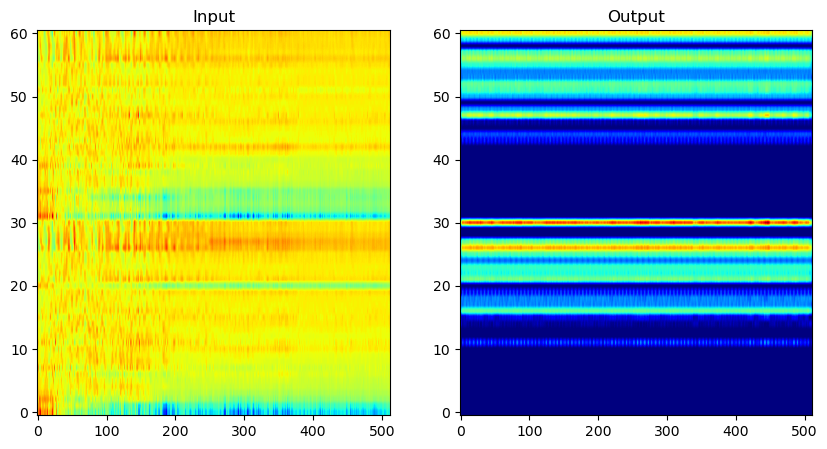

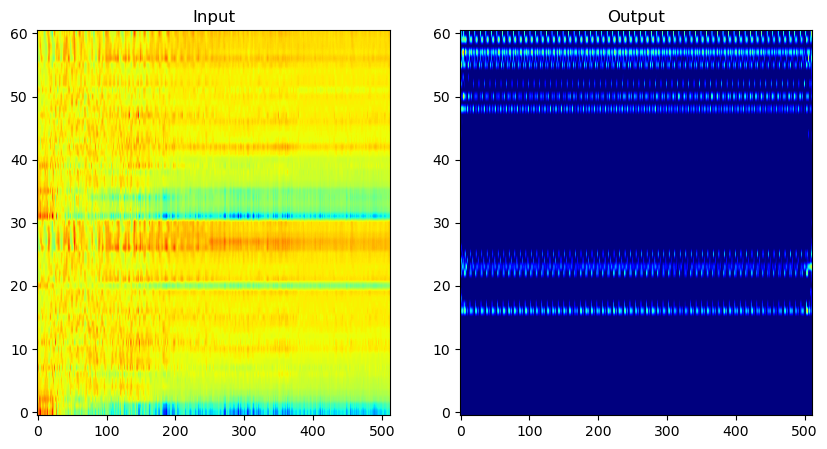

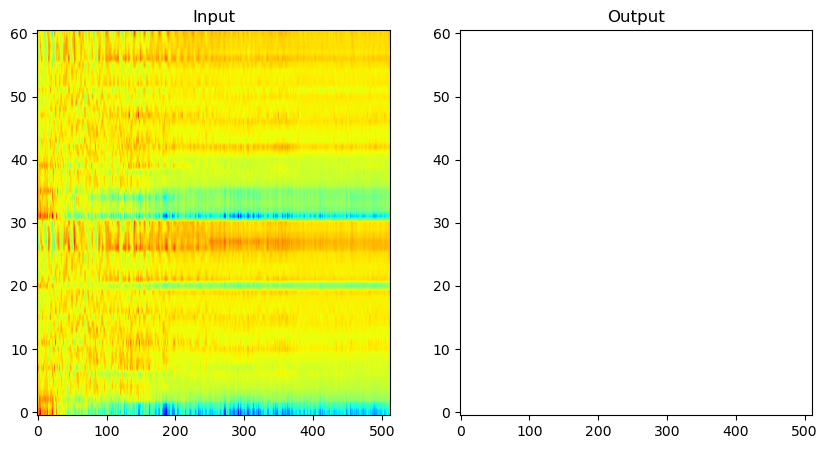

In [ ]:
for i, model in enumerate(models):
    # reconsrcution
    x_ = model.encoder_conv(x)
    mu = model.encoder_fc_mu(x_)
    log_var = model.encoder_fc_log_var(x_)
    std = torch.exp(0.5 * log_var)
    eps = torch.randn_like(std)
    z = mu + eps * std
    x_hat = model.decoder(z)

    # plot the output
    import matplotlib.pyplot as plt
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(x.detach().numpy()[0, :, :], aspect='auto', origin='lower', cmap='jet')
    axs[0].set_title('Input')
    axs[1].imshow(x_hat.detach().numpy()[0, :, :], aspect='auto', origin='lower', cmap='jet')
    axs[1].set_title('Output')

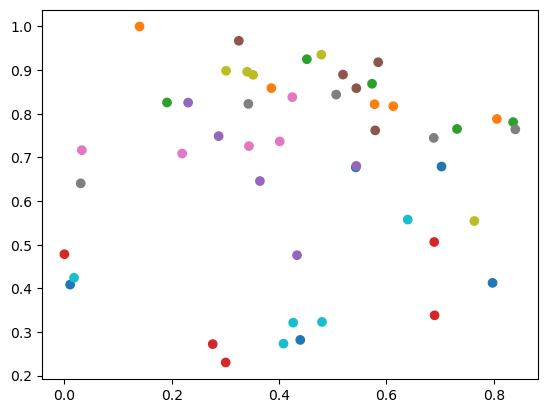

In [ ]:
# plot the latent space
from sklearn.manifold import TSNE
import numpy as np
tsne = TSNE()
X_data_2D = tsne.fit_transform(z.cpu().detach().numpy())
X_data_2D = (X_data_2D - X_data_2D.min()) / (X_data_2D.max() - X_data_2D.min())
# plot the output
plt.scatter(X_data_2D[:, 0],
            X_data_2D[:, 1],
            c=np.arange(X_data_2D.shape[0]),
            cmap=plt.cm.tab10
            )

## Define a position attribute for the dataset

In [ ]:
import mne
import torch
import typing as tp
import numpy as np
import torch.nn as nn
import math
from src.EEGNet.preprocessing.utils import get_channel_positions, get_headpoints

pos_dir = 'data/EEG_Localizer_BIDS_ID/'
sub_id = 'sub-010005'
EEG = mne.io.read_raw_brainvision('data/raw/sub-032304/RSEEG/sub-010005.vhdr')
EEG.set_channel_types({'VEOG': 'eog'})

position = get_channel_positions(pos_dir)[sub_id]
headpoint = get_headpoints(pos_dir)[sub_id]
head1, head2 = headpoint['first'], headpoint['second']
head = np.array([(h1+h2)/2 for h1, h2 in zip(head1.values(), head2.values())])
# montage = mne.channels.make_dig_montage(ch_pos=position, nasion=head[0], lpa=head[1], rpa=head[2])
montage = mne.channels.make_standard_montage('standard_1020')

EEG.set_montage(montage)

EEG.pick(['eeg'])
info = EEG.info
layout = mne.channels.find_layout(EEG.info)
position = torch.full((len(info.ch_names), 2), -0.1)
x, y = layout.pos[:, :2].T
x = (x - x.min()) / (x.max() - x.min())
y = (y - y.min()) / (y.max() - y.min())
x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()
position[:, 0] = x
position[:, 1] = y

# open xarray
import xarray as xr
from pathlib import Path
data_dir = Path('data/processed/normalized_clamped/eeg_EC_BaseCorr_Norm_Clamp.nc5')
import numpy as np

ds = xr.open_dataset(data_dir)
# concatenate position and the dataset
ds = ds.assign_attrs({'ch_positions': np.array(position)})
# overwrite the dataset
# ds.to_netcdf('data/data_with_positions.nc5', engine='h5netcdf')

In [ ]:
# create a rand torch with the specific shape
x = torch.rand(3, 61, 129)
n_embeddings = 32
n_channels = 61
# Encoder
encoder_conv = nn.Sequential(
            nn.Conv1d(n_channels, n_channels * 2, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv1d(n_channels * 2, n_channels * 4, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv1d(n_channels * 4, n_channels * 8, kernel_size=4, stride=2),
            nn.ReLU(),
            # nn.Flatten(),
        )

encoder_fc_mu = nn.Linear(n_channels * 8 * 62, n_embeddings)
encoder_fc_log_var = nn.Linear(n_channels * 8 * 62, n_embeddings)

encoder_conv(x).shape

torch.Size([3, 488, 14])

## Implement ranking head

In [ ]:
from src.EEGNet.dataloader.dataloader import EEGNetDataModuleKFold
# from src.EEGNet.models.cnn import CNN

datamodule = EEGNetDataModuleKFold(data_dir=data_dir,
                                   batch_size=batch_size,
                                   segment_size=segment_size,
                                   n_subjects=3,
                                   n_folds=3)
model = CNN(n_subjects=3,
            n_timepoints=14,  # 14 when using wavelets, this is a temporary fix
            use_classifier=True,
            use_decoder=False,
            use_1x1_conv=False,
            use_subject_layers=False,
            use_channel_merger=False,
            n_fft=256,
            )

# trainer = pl.Trainer(accelerator='cpu', log_every_n_steps=1, deterministic='warn')
# trainer.fit(model, datamodule=datamodule)

In [ ]:
import xarray as xr
data = xr.open_dataset(data_dir)

(array([ 1.,  0.,  3.,  3.,  9., 18., 15., 54., 58., 38.]),
 array([ 0. ,  2.7,  5.4,  8.1, 10.8, 13.5, 16.2, 18.9, 21.6, 24.3, 27. ]),
 <BarContainer object of 10 artists>)

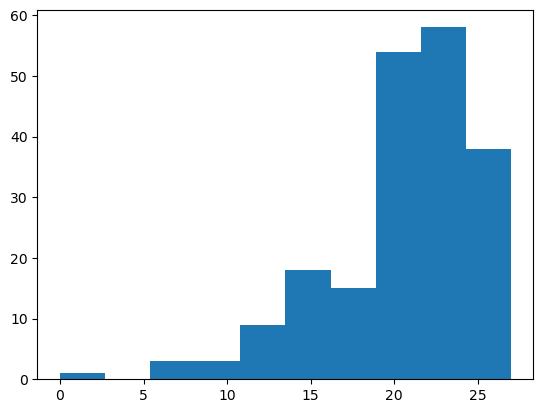

In [17]:
target = data.attrs['calmness']
# drop na values in numpy
target = target[~np.isnan(target)]
# # min_max normalization
target = (target - target.min())
plt.hist(target)

## Dropout and noise

Text(0.5, 1.0, 'Output')

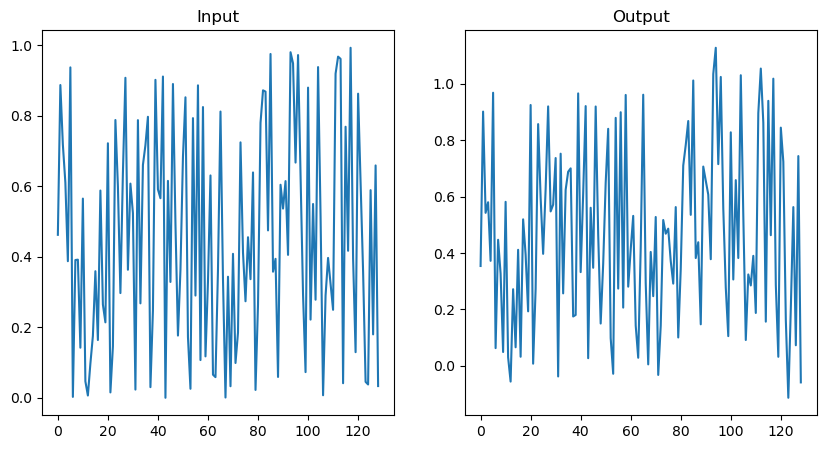

In [41]:
# random data
import torch
import torch.nn as nn
from torchaudio.transforms import Spectrogram
import matplotlib.pyplot as plt
x = torch.rand(3, 61, 129)
# x = Spectrogram(n_fft=256)(x).mean(dim=-1)
# # decibel transformation
# x = 10 * torch.log10(x)
# out = nn.Dropout(0.9)(x)
# add gaussian noise to the data
noise = torch.randn_like(x) * 0.1
out = x + noise

# visualize the input and out
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(x.detach().numpy()[0, 0, :])
axs[0].set_title('Input')
axs[1].plot(out.detach().numpy()[0, 0, :])
axs[1].set_title('Output')